## Automatyczne Uczenie Maszynowe
#### Laboratorium 3

*Optymalizacja hiperparametrów.*

### Wstęp
----
Podczas najbliższych zajęć będziemy pracować z optymalizacją bayesowską. Na początku będziemy pracować z pakietem  `scikit-optimize` . 

https://scikit-optimize.github.io/stable/

https://colab.research.google.com/github/krasserm/bayesian-machine-learning/blob/master/bayesian_optimization.ipynb#scrollTo=sJMlow8JPDoi


We are interested in solving

\begin{align}x^* = arg \min_x f(x)\end{align}

under the constraints that

- $f$ is a black box for which no closed form is known
  (nor its gradients);
- $f$ is expensive to evaluate;
- and evaluations of $y = f(x)$ may be noisy.


In [ ]:
# !pip install scikit-optimize

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

X_optimal = np.array([-0.359394])
Y_optimal = f(X_optimal)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15968\2132356131.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)


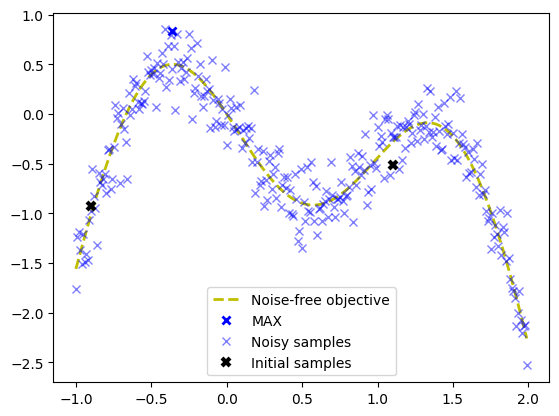

In [2]:
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X_optimal, Y_optimal, 'bx', mew=2, label='MAX')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.5, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

#### Bayesian optimization loop

For $t=1:T$:

1. Given observations $(x_i, y_i=f(x_i))$ for $i=1:t$, build a
   probabilistic model for the objective $f$. Integrate out all
   possible true functions, using Gaussian process regression.

2. optimize a cheap acquisition/utility function $u$ based on the
   posterior distribution for sampling the next point.
   $x_{t+1} = arg \min_x u(x)$
   Exploit uncertainty to balance exploration against exploitation.

3. Sample the next observation $y_{t+1}$ at $x_{t+1}$.

In [3]:
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern
from skopt.plots import plot_convergence, plot_gaussian_process
from bayesian_optimization_util import plot_approximation, plot_acquisition

# Use custom kernel and estimator to match previous example
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

res = gp_minimize(lambda x: -f(np.array(x))[0], 
                bounds.tolist(),
                base_estimator=gpr,
                acq_func='EI',      # expected improvement
                xi=0.01,            # exploitation-exploration trade-off
                n_calls=30,         # number of iterations
                n_random_starts
                =0,  # initial samples are provided
                x0=X_init.tolist(), # initial samples
                y0=-Y_init.ravel())

print("Selected argument x^*=%.4f,  with f(x^*)=%.4f" % (res.x[0], res.fun))

# print(res)


c:\Users\Lenovo\Documents\Teaching\2024\2024Z-AutoML\automl_basic\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [-1.0, 2.0] was inferred to Real(low=-1.0, high=2.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(-1.0, 2.0), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(


Selected argument x^*=-0.3738,  with f(x^*)=-0.8211


For further inspection of the results, attributes of the `res` named tuple
provide the following information:

- `x` [float]: location of the minimum.
- `fun` [float]: function value at the minimum.
- `models`: surrogate models used for each iteration.
- `x_iters` [array]:
  location of function evaluation for each iteration.
- `func_vals` [array]: function value for each iteration.
- `space` [Space]: the optimization space.
- `specs` [dict]: parameters passed to the function.

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

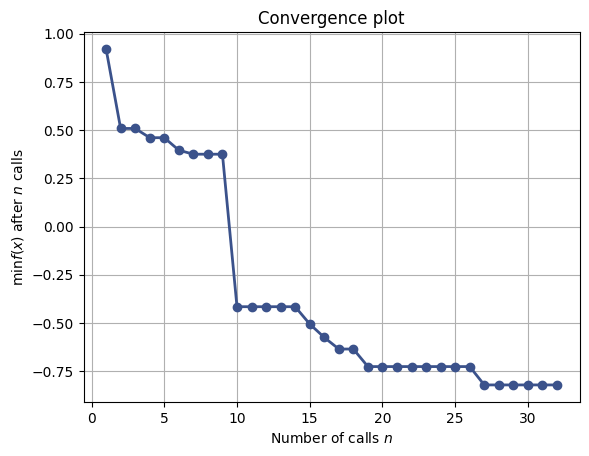

In [4]:
###

plot_convergence(res)

<Axes: xlabel='x', ylabel='f(x)'>

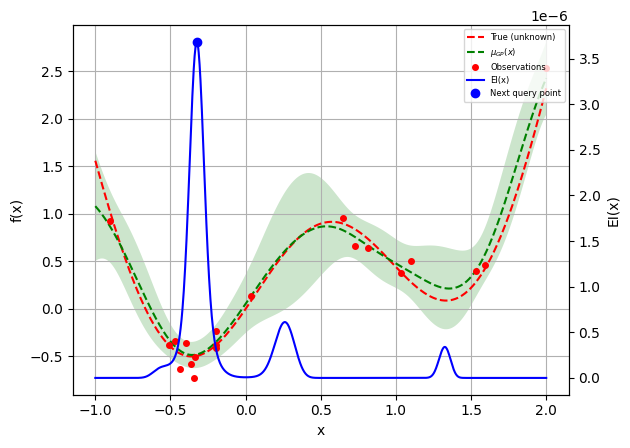

In [6]:
def f_wo_noise(x):
    return -f(x, noise=0)

plot_gaussian_process(res, n_calls=20, objective=f_wo_noise,
                               show_legend=True, show_title=False,
                               show_mu=True, show_acq_func=True,
                               show_observations=True,
                               show_next_point=True)



### Zadanie 1

Na podstawie powyższych wykresów przeanalizuj jak zmienia się surrogate model i acqusition function wraz a kolejnymi iteracjami optymalizacji (np. w 5 losowo wybranych numerach iteracji).

### Zadanie 2 (Exploration vs. Exploitation)
Zbadaj zjawisko Exploration vs. Exploitation rysując wykres odległości pomiędzy testowanymi punktami w kolejnych iteracjach, a obok wykres jakości proponowanych punktów (czyli wartości funkcji w punkcie).

### Zadanie 3 (Acqusition Function)

Przeanalizuj jak zmienia się działanie optymalizacji bayesowskiej w zależności od Acqusition Function. Zobacz czy i jak zmieniają się rozkłady proponowanych punktów. 

### Zadanie 4

Wykorzystując powyższy kod przeprowadź optymalizację bayesowską hiperparametru `alpha`  dla algorytmu Elastic Net z pakietu sklearn. Wartości funkcji w punkcie powinny być oszacowane jako średnia z 5-krotnej kroswalidacji. Optymalizację przeprowadź dla sztucznie wygenerowanego zbioru danych.

In [7]:
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
X, y, true_coef = make_regression(
   n_samples=100, n_features=5, n_informative=2, coef=True, random_state=0
)

### TODO


## BayesSearchCV

Aby wygodniej pracować i wykorzystywać BO w sklearnie powstał wrapper `BayesSearchCV`. 


In [57]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram

from sklearn.datasets import load_digits
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X, y = load_digits(n_class=10, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# pipeline class is used as estimator to enable
# search over different model types
pipe = Pipeline([
    ('model', SVC())
])

# single categorical value of 'model' parameter is
# sets the model class
# We will get ConvergenceWarnings because the problem is not well-conditioned.
# But that's fine, this is just an example.
linsvc_search = {
    'model': [LinearSVC(max_iter=1000)],
    'model__C': (1e-6, 1e+6, 'log-uniform'),
}

# explicit dimension classes can be specified like this
svc_search = {
    'model': Categorical([SVC()]),
    'model__C': Real(1e-6, 1e+6, prior='log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'model__degree': Integer(1,8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

opt = BayesSearchCV(
    pipe,
    # (parameter space, # of evaluations)
    [(svc_search, 40), (linsvc_search, 16)],
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))

val. score: 0.9851521900519673
test score: 0.9822222222222222
best params: OrderedDict({'model': SVC(), 'model__C': 0.02664724411534717, 'model__degree': 4, 'model__gamma': 0.001456330329899919, 'model__kernel': 'poly'})


### Zadanie 5

Przeprowadź optymalizację bayesowską dla pipeline i danych wykorzystywanych na Laboratoriach 1 i 2. Porównaj otrzymane wyniki z oprymalizacją poprzez `RandomSearchCV`.